In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import random
from itertools import product
%matplotlib inline

In [2]:
def words_to_vocabulary(words):
    """
        Build the vocabulary of characters and mappings to/from integers.
    """
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi['.'] = 0
    itos = {i:s for s,i in stoi.items()}
    return stoi, itos

def build_dataset_from_words(words, n):
    """
        Build a dataset of n-tuples from words where the x's are the first (n-1) elements in the tuples, and the y's are the last element.
    :param list of str words: list of words.
    :param int n: tuples length to consider.
    """
    X, Y = [], []
    for w in words:
        context = [0] * (n-1)
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

class NGrams(nn.Module):
    """
        Class for n-grams models in the style of PyTorch modules so that is has a forward pass.
    """
    def __init__(self, words, n, smoothing=0):
        super().__init__()
        self.n = n
        self.smoothing = smoothing
        self.stoi, _ = words_to_vocabulary(words)
        self.voc_len = len(self.stoi)
        self.P = self._build_ngram_model(words, n, smoothing)

    def _build_ngram_model(self, words, n, smoothing):
        """
            Make counts of n-tuples in words.
        :param list of str words: dataset of words.
        :param int n: tuples length.
        """
        voc_len = self.voc_len
        n = self.n
        
        if n == 0:
            return torch.ones(voc_len) / voc_len
        N = torch.zeros([voc_len] * n, dtype=torch.int32)
        for w in words:
            chs = ['.'] * (n - 1) + list(w) + ['.']
            for ch in zip(*[chs[i:] for i in range(n)]):
                ix = [[self.stoi[c]] for c in ch]
                N[ix] += 1
        
        P = N.float()
        P += smoothing
        P /= P.sum(-1, keepdims=True)
        return P
    
    def forward(self, x):
        if len(x[0]):
            return self.P[x.t().split(1)][0]
        else:
            bs = len(x)
            return self.P[None].repeat([bs, 1])

def nll(proba, Y):
    return proba[range(len(Y)), Y].log().mul(-1).mean().item()

Toy dataset

In [3]:
words = ['ab', 'bb', 'ba']

In [4]:
ns = [0, 1, 2]
smoothing_vals = [0, 1]

for n, smoothing in product(ns, smoothing_vals):
    m = NGrams(words[:-1], n=n, smoothing=smoothing)
    stoi, itos = words_to_vocabulary(words)

    Xtr, Ytr = build_dataset_from_words(words[:-1], n=n)
    Xte, Yte = build_dataset_from_words([words[-1]], n=n)

    otr = m(Xtr)
    ote = m(Xte)

    ltr, lte = nll(otr, Ytr), nll(ote, Yte)
    
    print(fr'{n=},  {smoothing=},    train loss: {ltr:<4.02f},     test loss: {lte:.02f}')

n=0,  smoothing=0,    train loss: 1.10,     test loss: 1.10
n=0,  smoothing=1,    train loss: 1.10,     test loss: 1.10
n=1,  smoothing=0,    train loss: 1.01,     test loss: 1.19
n=1,  smoothing=1,    train loss: 1.02,     test loss: 1.14
n=2,  smoothing=0,    train loss: 0.55,     test loss: inf
n=2,  smoothing=1,    train loss: 0.84,     test loss: 1.36


Print $P^{(2)}$ for 2-grams

In [5]:
m = NGrams(words[:-1], n=n, smoothing=smoothing)
P = m.P

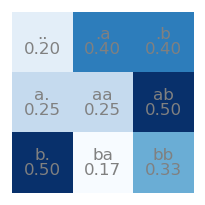

In [6]:
plt.figure(figsize=(2, 2), dpi=120)
voc_len = len(stoi)
plt.imshow(P, cmap='Blues')
for i in range(voc_len):
    for j in range(voc_len):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, f'{P[i, j].item():.02f}', ha="center", va="top", color='gray')
plt.axis('off');

Actual words

In [7]:
# longer list of names (~9k). Some are not native Italian.
words = open('names.txt', 'r').read().splitlines()

# words preprocessing (fix accents, remove dotted names)
words = [w for w in words if not ',' in w and not '.' in w and w != "nicolo'" and len(w) >= 3]
for i in range(len(words)):
    if "‡" in words[i]:
        words[i] = words[i][:-1] + "à"
    if "˘" in words[i]:
        words[i] = words[i][:-1] + "ù"
    if "Ú" in words[i]:
        words[i] = words[i][:-1] + "ò"
    if "Ï" in words[i]:
        words[i] = words[i][:-1] + "ì"
    if "Ë" in words[i]:
        words[i] = words[i][:-1] + "è"
stoi, itos = words_to_vocabulary(words)

Compute train and test losses for n-grams and different smoothing values

In [ ]:
random.seed(42)
random.shuffle(words)

# train-test splitting size
n1 = int(0.9*len(words))

ltr, lte = [[], []], [[], []]
smoothing_val = [1e-8, .1]

for i, smoothing in enumerate(smoothing_val):
    for n in range(7):
        
        m = NGrams(words[:n1], n=n, smoothing=smoothing)

        Xtr, Ytr = build_dataset_from_words(words[:n1], n=n)
        Xte, Yte = build_dataset_from_words(words[n1:], n=n)

        otr = m(Xtr)
        ote = m(Xte)

        ltr[i].append(nll(otr, Ytr))
        lte[i].append(nll(ote, Yte))
        
        print(fr'{n=},  {smoothing=:<5},    train loss: {ltr[i][-1]:<4.02f},     test loss: {lte[i][-1]:.02f}')

n=0,  smoothing=1e-08,    train loss: 3.50,     test loss: 3.50
n=1,  smoothing=1e-08,    train loss: 2.73,     test loss: 2.73
n=2,  smoothing=1e-08,    train loss: 2.17,     test loss: 2.18
n=3,  smoothing=1e-08,    train loss: 1.89,     test loss: 2.01
n=4,  smoothing=1e-08,    train loss: 1.53,     test loss: 2.42
n=5,  smoothing=1e-08,    train loss: 1.26,     test loss: 2.93
n=6,  smoothing=1e-08,    train loss: 1.15,     test loss: 3.36
n=0,  smoothing=0.1  ,    train loss: 3.50,     test loss: 3.50
n=1,  smoothing=0.1  ,    train loss: 2.73,     test loss: 2.73
n=2,  smoothing=0.1  ,    train loss: 2.17,     test loss: 2.17


In [ ]:
_, ax = plt.subplots(1, 2, figsize=(7, 2), dpi=150, sharey=True, sharex=True)
for i, smoothing in enumerate(smoothing_val):
    plt.sca(ax[i])
    plt.title(f'{smoothing=}', fontsize=9)
    plt.plot(ltr[i], c=f'C0', label='train loss', lw=2, alpha=.75)   # '--' if i else '-' if not i else None
    plt.plot(lte[i], c=f'C1', label='test loss', lw=2, alpha=.75)   # '--' if i else '-' if not i else None
    plt.xlabel('$n$', fontsize=15)
    plt.legend()
    if not i:
        plt.ylabel('loss', fontsize=15)
plt.tight_layout(pad=0)